## 1. Volatility changes over time
<p>What is financial risk? </p>
<p>Financial risk has many faces, and we measure it in many ways, but for now, let's agree that it is a measure of the possible loss on an investment. In financial markets, where we measure prices frequently, volatility (which is analogous to <em>standard deviation</em>) is an obvious choice to measure risk. But in real markets, volatility changes with the market itself. </p>
<p><img src="https://assets.datacamp.com/production/project_738/img/VolaClusteringAssetClasses.png" alt=""></p>
<p>In the picture above, we see the returns of four very different assets. All of them exhibit alternating regimes of low and high volatilities. The highest volatility is observed around the end of 2008 - the most severe period of the recent financial crisis.</p>
<p>In this notebook, we will build a model to study the nature of volatility in the case of US government bond yields.</p>

In [3]:
PATH = "C:/Users/tantr/Dropbox/1_WORK/Coding/ML_CODING/Data"
setwd(PATH)
getwd()

# Load the packages
library(xts)
library(readr)

# Load the data
yc_raw <- read_csv("FED-SVENY.csv")

# Convert the data into xts format
yc_all <- as.xts(x = yc_raw[, -1], order.by = yc_raw$Date)

# Show only the 1st, 5th, 10th, 20th and 30th columns
yc_all_tail <- tail(yc_all[, c(1, 5, 10, 20, 30)])
yc_all_tail

[1] "C:/Users/tantr/Dropbox/1_WORK/Coding/ML_CODING/Data"

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Parsed with column specification:
cols(
  .default = col_double(),
  Date = col_date(format = "")
)

See spec(...) for full column specifications.



           SVENY01 SVENY05 SVENY10 SVENY20 SVENY30
2019-03-22  2.4222  2.2613  2.4553  2.7661  3.0178
2019-03-25  2.3901  2.2281  2.4449  2.7610  3.0216
2019-03-26  2.3811  2.2016  2.4249  2.7508  3.0138
2019-03-27  2.3560  2.1931  2.4020  2.7092  2.9785
2019-03-28  2.3601  2.2137  2.4058  2.6907  2.9605
2019-03-29  2.3719  2.2398  2.4143  2.6939  2.9538

## 2. Plotting the evolution of bond yields
<p>In the output table of the previous task, we see the yields for some maturities.</p>
<p>These data include the whole yield curve. The yield of a bond is the price of the money lent. The higher the yield, the more money you receive on your investment. The yield curve has many maturities; in this case, it ranges from 1 year to 30 years. Different maturities have different yields, but yields of neighboring maturities are relatively close to each other and also move together.</p>
<p>Let's visualize the yields over time. We will see that the long yields (e.g. SVENY30) tend to be more stable in the long term, while the short yields (e.g. SVENY01) vary a lot. These movements are related to the monetary policy of the FED and economic cycles.</p>

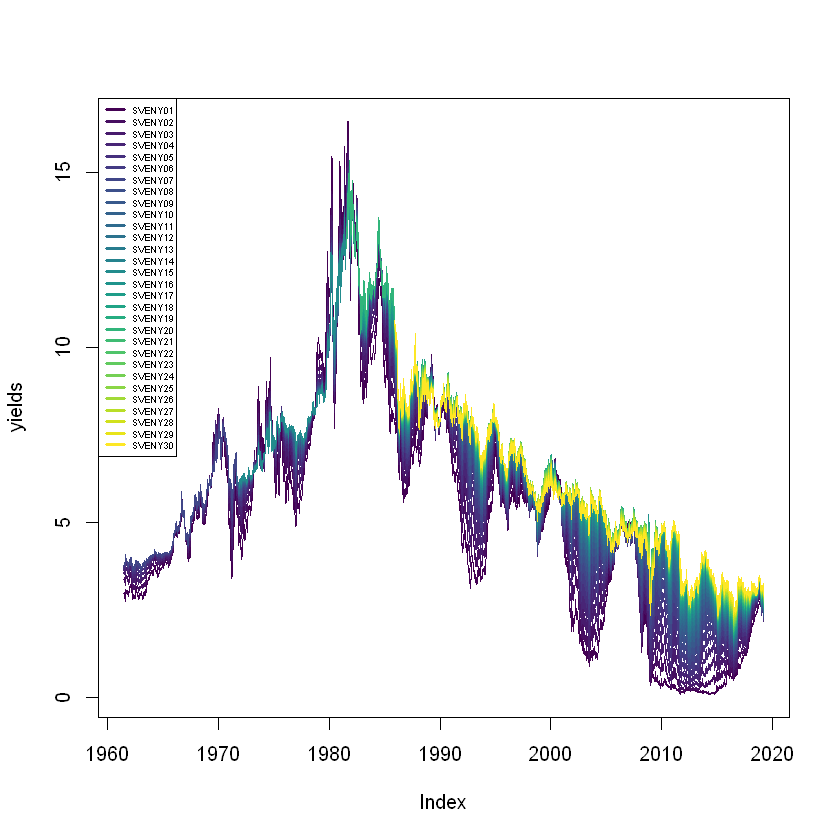

In [5]:
library(viridis)

# Define plot arguments
yields  <- yc_all
plot.type  <- "single"
plot.palette <- viridis(30)
asset.names <- colnames(yc_all)

# Plot the time series
plot.zoo(x = yields, plot.type = plot.type, col = plot.palette)

# Add the legend
legend(x = "topleft", legend = asset.names,
       col = plot.palette, cex = 0.45, lwd = 3)

## 3. Make the difference
<p>In the output of the previous task, we see the level of bond yields for some maturities, but to understand how volatility evolves we have to examine the changes in the time series. Currently, we have yield levels; we need to calculate the changes in the yield levels. This is called "differentiation" in time series analysis. Differentiation has the added benefit of making a time series independent of time.</p>

In [6]:
# Differentiate the time series  
ycc_all <- diff.xts(yc_all)

# Show the tail of the 1st, 5th, 10th, 20th and 30th columns
ycc_all_tail <- tail(ycc_all[, c(1, 5, 10, 20, 30)])
ycc_all_tail

           SVENY01 SVENY05 SVENY10 SVENY20 SVENY30
2019-03-22 -0.0412 -0.1039 -0.0878 -0.0924 -0.0864
2019-03-25 -0.0321 -0.0332 -0.0104 -0.0051  0.0038
2019-03-26 -0.0090 -0.0265 -0.0200 -0.0102 -0.0078
2019-03-27 -0.0251 -0.0085 -0.0229 -0.0416 -0.0353
2019-03-28  0.0041  0.0206  0.0038 -0.0185 -0.0180
2019-03-29  0.0118  0.0261  0.0085  0.0032 -0.0067

## 4. The US yields are no exceptions, but maturity matters
<p>Now that we have a time series of the changes in US government yields let's examine it visually.</p>
<p>By taking a look at the time series from the previous plots, we see hints that the returns following each other have some unique properties:</p>
<ul>
<li>The direction (positive or negative) of a return is mostly independent of the previous day's return. In other words, you don't know if the next day's return will be positive or negative just by looking at the time series.</li>
<li>The magnitude of the return is similar to the previous day's return. That means, if markets are calm today, we expect the same tomorrow. However, in a volatile market (crisis), you should expect a similarly turbulent tomorrow.</li>
</ul>

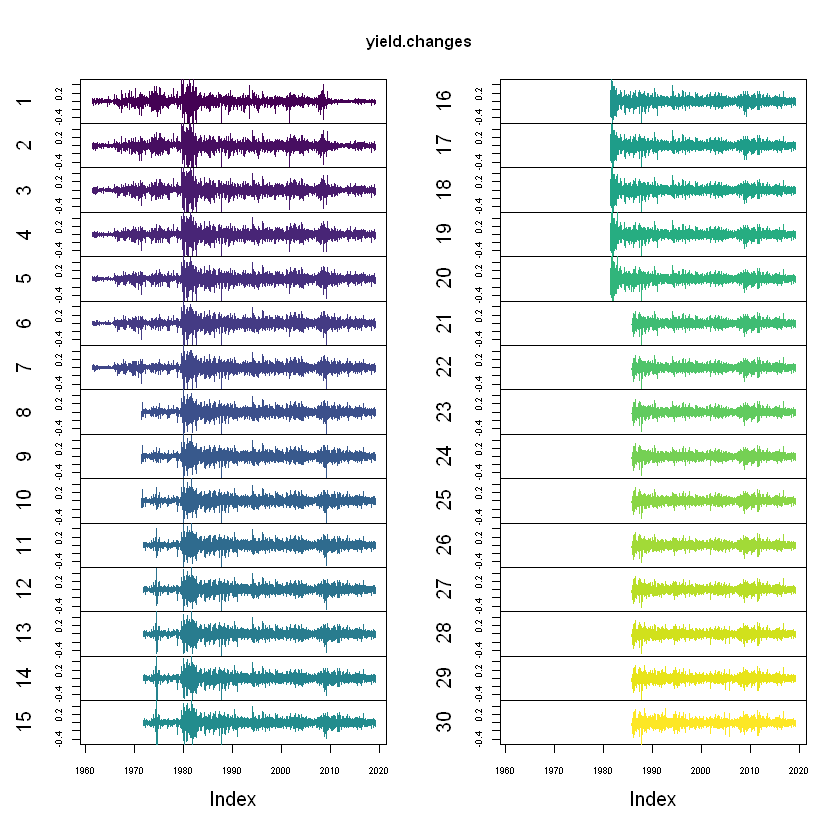

In [7]:
# Define the plot parameters
yield.changes <- ycc_all
plot.type <- "multiple"


# Plot the differtianted time series
plot.zoo(x = yield.changes, plot.type = plot.type, 
     ylim = c(-0.5, 0.5), cex.axis = 0.7, 
     ylab = 1:30, col = plot.palette)

## 5. Let's dive into some statistics
<p>The statistical properties visualized earlier can be measured by analytical tools. The simplest method is to test for autocorrelation. Autocorrelation measures how a datapoint's past determines the future of a time series. </p>
<ul>
<li>If the autocorrelation is close to 1, the next day's value will be very close to today's value. </li>
<li>If the autocorrelation is close to 0, the next day's value will be unaffected by today's value.</li>
</ul>
<p>Because we are interested in the recent evolution of bond yields, we will filter the time series for data from 2000 onward.</p>

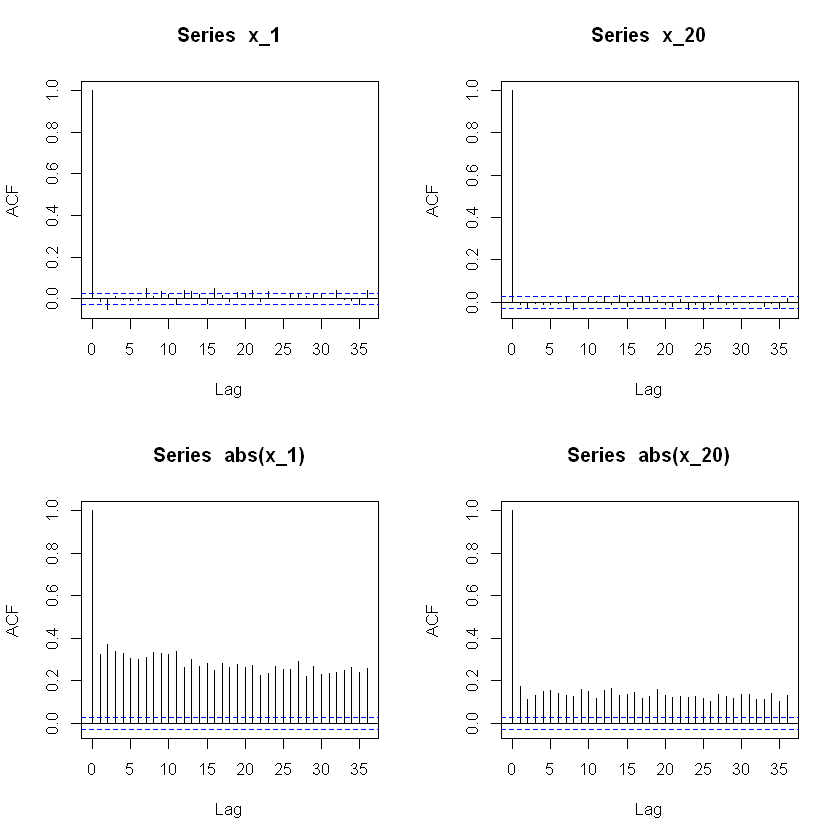

In [8]:
# Filter for changes in and after 2000
ycc <- ycc_all["2000/", ]

# Save the 1-year and 20-year maturity yield changes into separate variables
x_1 <- ycc[, "SVENY01"]
x_20 <- ycc[, "SVENY20"]

# Plot the autocorrelations of the yield changes
par(mfrow=c(2,2))
acf_1 <- acf(x_1)
acf_20 <- acf(x_20)

# Plot the autocorrelations of the absolute changes of yields
acf_abs_1 <- acf(abs(x_1))
acf_abs_20 <- acf(abs(x_20))

## 6. GARCH in action
<p>A Generalized AutoRegressive Conditional Heteroskedasticity (<a href="https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity">GARCH</a>) model is the most well known econometric tool to handle changing volatility in financial time series data. It assumes a hidden volatility variable that has a long-run average it tries to return to while the short-run behavior is affected by the past returns.</p>
<p>The most popular form of the GARCH model assumes that the volatility follows this process:
</p><p></p>
<math>
    &sigma;<sup>2</sup><sub>t</sub> = &omega; + &alpha; ⋅ &epsilon;<sup>2</sup><sub>t-1</sub> + &beta; ⋅ &sigma;<sup>2</sup><sub>t-1</sub>
</math>
<p></p><p></p>
<math>        
where &sigma; is the current volatility, &sigma;<sub>t-1</sub> the last day's volatility and &epsilon;<sub>t-1</sub> is the last day's return. The estimated parameters are &omega;, &alpha;, and &beta;.
</math>
<p>For GARCH modeling we will use <a href="https://cran.r-project.org/web/packages/rugarch/index.html"><code>rugarch</code></a> package developed by Alexios Ghalanos.</p>

Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma




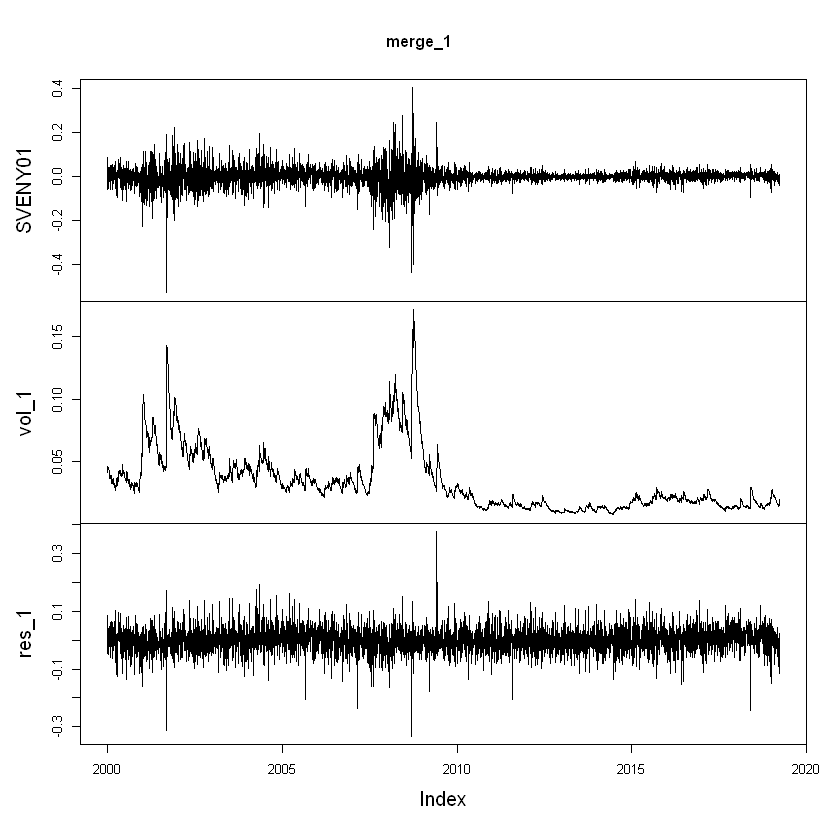

In [9]:
library(rugarch)
# Specify the GARCH model with the skewed t-distribution
spec <- ugarchspec(distribution.model = "sstd")

# Fit the model
fit_1 <- ugarchfit(x_1, spec = spec)

# Save the volatilities and the rescaled residuals
vol_1 <- sigma(fit_1)
res_1 <- scale(residuals(fit_1, standardize = TRUE)) * sd(x_1) + mean(x_1)

# Plot the yield changes with the estimated volatilities and residuals
merge_1 <- merge.xts(x_1, vol_1, res_1)
plot.zoo(merge_1)

## 7. Fitting the 20-year maturity
<p>Let's do the same for the 20-year maturity. As we can see in the plot from Task 6, the bond yields of various maturities show similar but slightly different characteristics. These different characteristics can be the result of multiple factors such as the monetary policy of the FED or the fact that the investors might be different.</p>
<p>Are there differences between the 1-year maturity and 20-year maturity plots?</p>

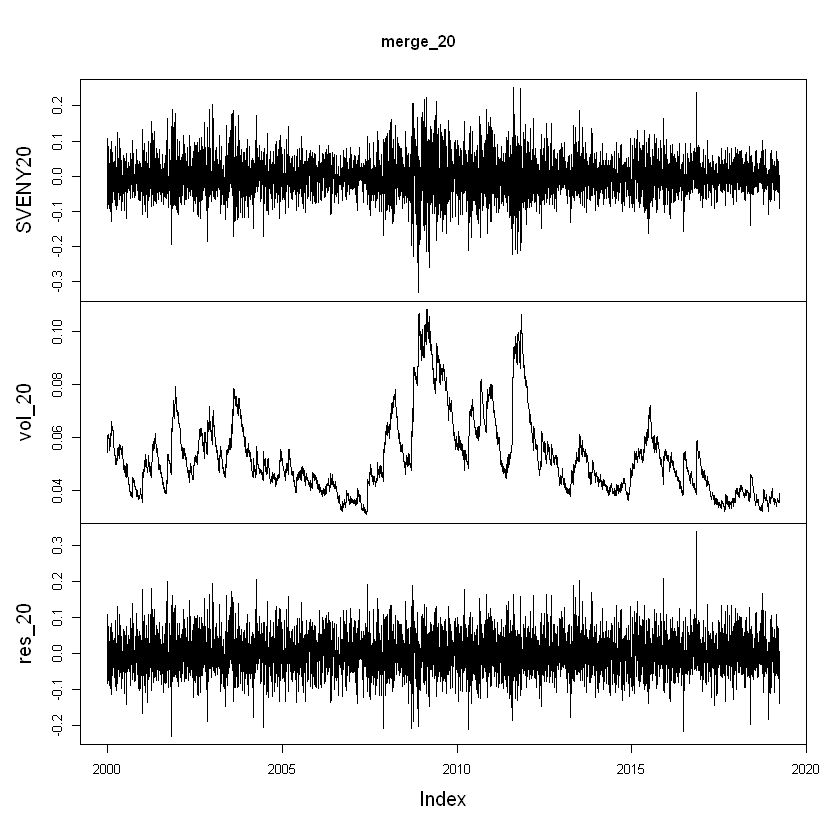

In [10]:
# Fit the model
fit_20 <- ugarchfit(x_20, spec = spec)

# Save the volatilities
vol_20 <- sigma(fit_20) 
res_20 <- scale(residuals(fit_20, standardize = TRUE)) * sd(x_20) + mean(x_20)

# Plot the yield changes with the estimated volatilities and residuals
merge_20 <- merge.xts(x_20, vol_20, res_20)
plot.zoo(merge_20)

## 8. What about the distributions? (Part 1)
<p>From the plots in Task 6 and Task 7, we can see that the 1-year GARCH model shows a similar but more erratic behavior compared to the 20-year GARCH model. Not only does the 1-year model have greater volatility, but the volatility of its volatility is larger than the 20-year model. That brings us to two statistical facts of financial markets not mentioned yet. </p>
<ul>
<li>The unconditional (before GARCH) distribution of the yield differences has heavier tails than the normal distribution.</li>
<li>The distribution of the yield differences adjusted by the GARCH model has lighter tails than the unconditional distribution, but they are still heavier than the normal distribution.</li>
</ul>
<p>Let's find out what the fitted GARCH model did with the distribution we examined.</p>

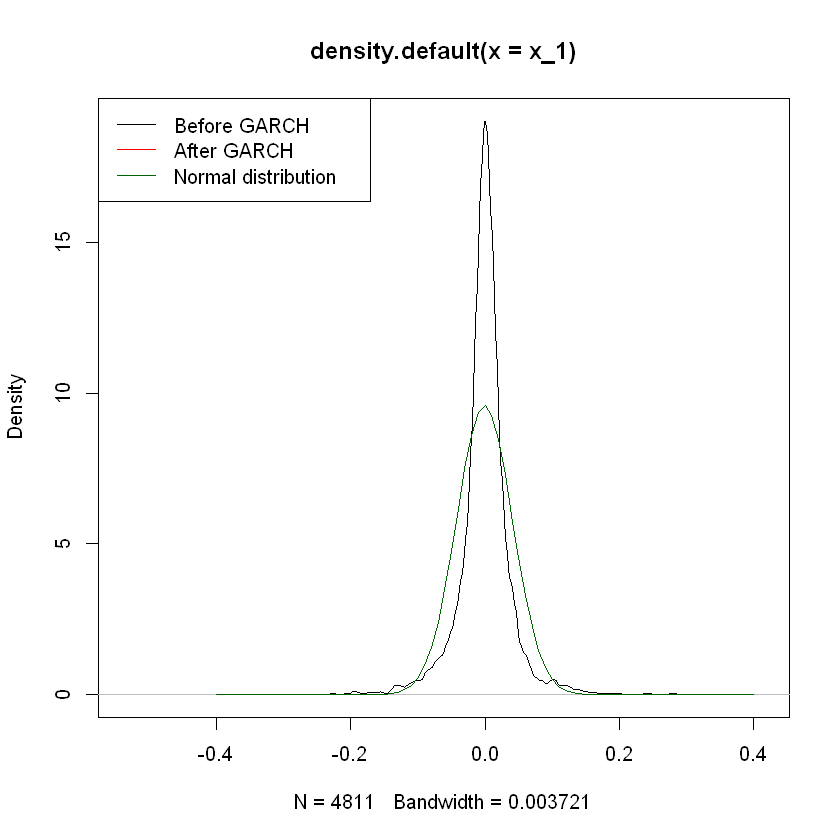

In [11]:
# Calculate the kernel density for the 1-year maturity and residuals
density_x_1 <- density(x_1)
density_res_1 <- density(res_1)

# Plot the density digaram for the 1-year maturity and residuals
plot(density_x_1)
lines(density_res_1, col = "red")

# Add the normal distribution to the plot
norm_dist <- dnorm(seq(-0.4, 0.4, by = .01), mean = mean(x_1), sd = sd(x_1))
lines(seq(-0.4, 0.4, by = .01), 
      norm_dist, 
      col = "darkgreen"
     )

# Add legend
legend <- c("Before GARCH", "After GARCH", "Normal distribution")
legend("topleft", legend = legend, 
       col = c("black", "red", "darkgreen"), lty=c(1,1))

## 9. What about the distributions? (Part 2)
<p>In the previous plot, we see that the two distributions from the GARCH models are different from the normal distribution of the data, but the tails, where the differences are the most profound, are hard to see. Using a Q-Q plot will help us focus in on the tails.</p>
<p>You can read an excellent summary of Q-Q plots <a href="https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot">here</a>.</p>

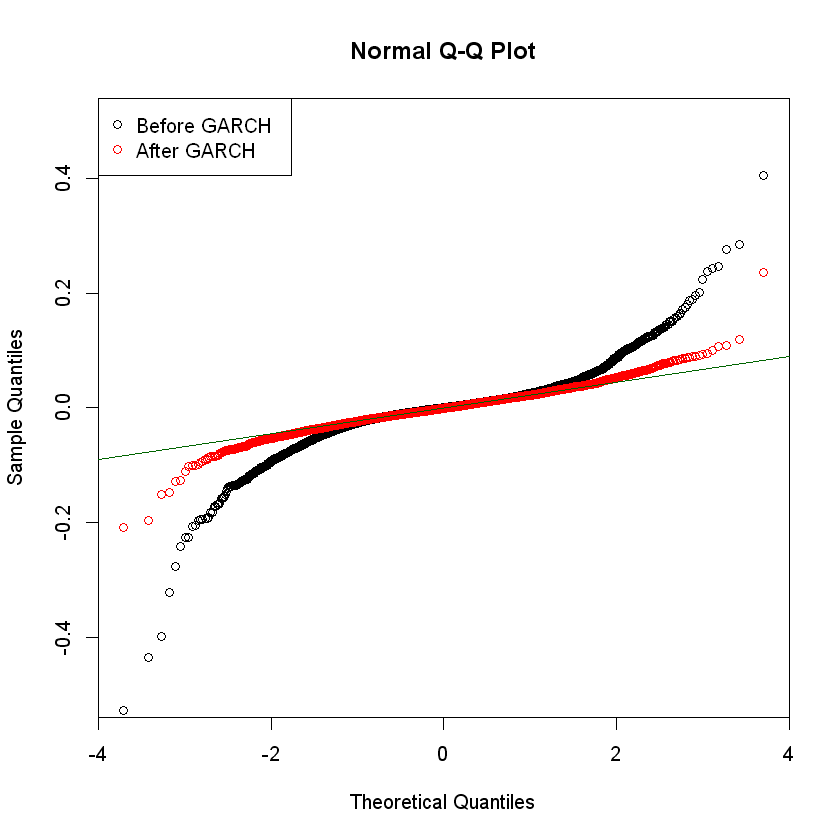

In [10]:
# Define plot data: the 1-year maturity yield changes and the residuals 
data_orig <- x_1
data_res <- res_1

# Define the benchmark distribution (qnorm)
distribution <- qnorm

# Make the Q-Q plot of original data with the line of normal distribution
qqnorm(data_orig, ylim = c(-0.5, 0.5))
qqline(data_orig, distribution = distribution, col = "darkgreen")

# Make the Q-Q plot of GARCH residuals with the line of normal distribution
par(new=TRUE)
qqnorm(data_res * 0.623695122815242, col = "red", ylim = c(-0.5, 0.5))
qqline(data_res * 0.623695122815242, distribution = distribution, col = "darkgreen")
legend("topleft", c("Before GARCH", "After GARCH"), col = c("black", "red"), pch=c(1,1))

## 10. A final quiz
<p>In this project, we fitted a GARCH model to develop a better understanding of how bond volatility evolves and how it affects the probability distribution. In the final task, we will evaluate our model. Did the model succeed, or did it fail?</p>

In [11]:
# Q1: Did GARCH revealed how volatility changed over time? # Yes or No?
(Q1 <- "Yes")

# Q2: Did GARCH bring the residuals closer to normal distribution? Yes or No?
(Q2 <- "Yes")

# Q3: Which time series shows the most erratic behaviour? Choose 1 or 20.
(Q3 <- 1)

[1] "Yes"

[1] "Yes"

[1] 1